In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#!python -m wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 
     

In [4]:
df = pd.read_csv('E:\My Projects\Bitpredict\input\BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', parse_dates=['Date'], dayfirst=True,index_col=['Date'])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'price'})
bitcoin_prices.head()

,price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 [Text(-500.0, 0, '2020-01-05'),
  Text(0.0, 0, '2013-10-01'),
  Text(500.0, 0, '2015-02-13'),
  Text(1000.0, 0, '2016-06-27'),
  Text(1500.0, 0, '2017-11-09'),
  Text(2000.0, 0, '2019-03-24'),
  Text(2500.0, 0, '2020-08-05'),
  Text(3000.0, 0, '')])

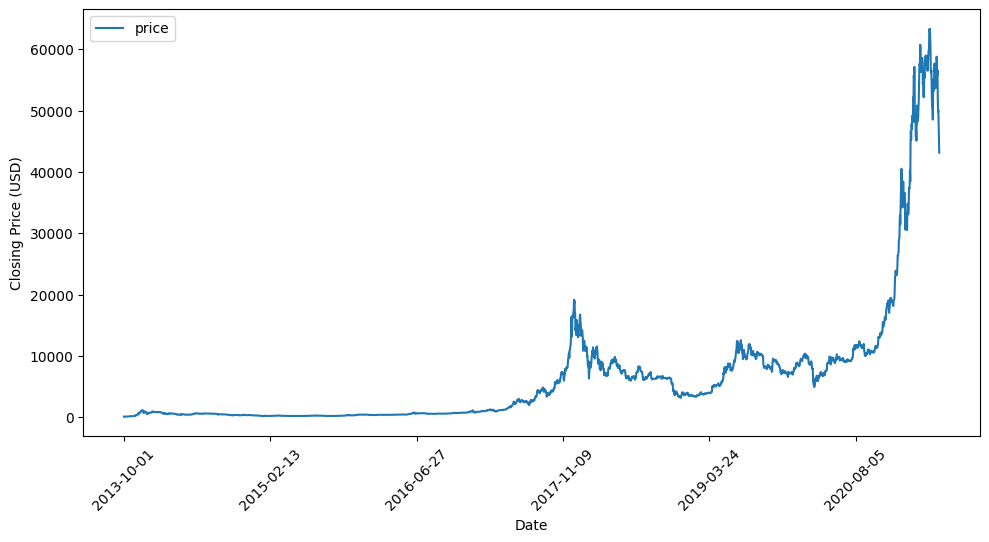

In [6]:
bitcoin_prices.plot(kind='line',figsize=(10,5))
plt.ylabel('Closing Price (USD)'),
plt.tight_layout()
plt.xticks(rotation=45)

In [7]:
# Define split point (e.g., 80% train, 20% test)
split_date = '2018-11-01'  # Adjust as needed

# Split the DataFrame
train = bitcoin_prices.loc[:split_date]
test = bitcoin_prices.loc[split_date:]

X_train = train.drop(columns=['price'])
y_train = train['price']
X_test = test.drop(columns=['price'])
y_test = test['price']

print("Train start:", train.index[0], "Train end:", train.index[-1])
print("Test start:", test.index[0], "Test end:", test.index[-1])


Train start: 2013-10-01 Train end: 2018-11-01
Test start: 2018-11-01 Test end: 2021-05-18


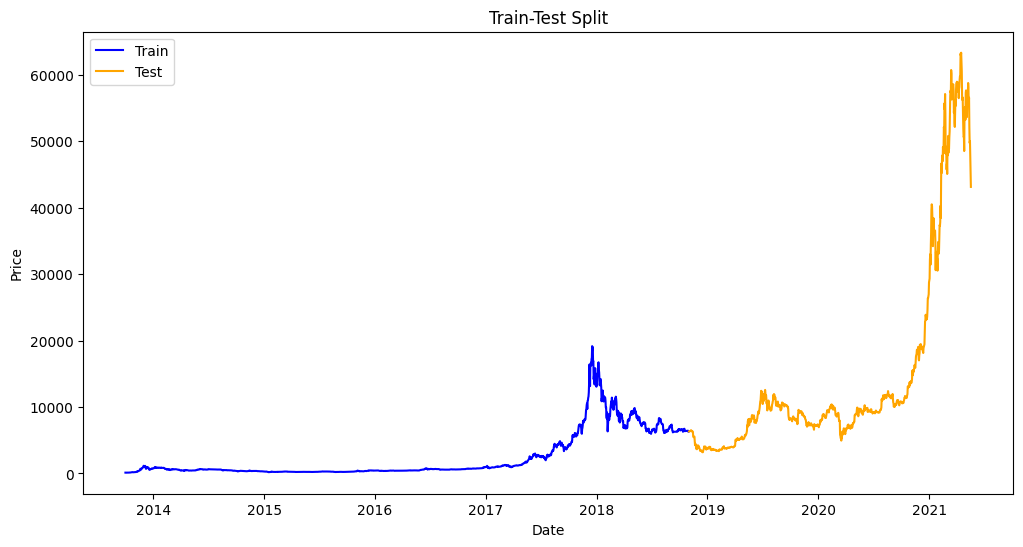

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Plot the training set
plt.figure(figsize=(12, 6))
train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
plt.plot(train.index, train['price'], label='Train', color='blue')

# Plot the testing set
plt.plot(test.index, test['price'], label='Test', color='orange')
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as 'YYYY'
# Add labels, legend, and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Train-Test Split')
plt.legend()
plt.show()




In [9]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [10]:
def evaluate_metric(ytrue,ypred):
    ytrue = tf.cast(ytrue,dtype='float32')
    ypred = tf.cast(ypred,dtype='float32')

    mae = tf.metrics.mean_absolute_error(ytrue,ypred)
    mse = tf.metrics.mean_squared_error(ytrue,ypred)
    RMSE = tf.sqrt(mse)
    mase = mean_absolute_scaled_error(ytrue, ypred)
    mape = tf.metrics.mean_absolute_percentage_error(ytrue,ypred)

    return {
        'mae':mae.numpy(),
        'mse':mse.numpy(),
        'RMSE':RMSE.numpy(),
        'mase':mase.numpy(),
        'mape':mape.numpy()
    }

In [11]:
import os
os.chdir('E:\\My Projects\\Bitpredict')

In [12]:

from src import config

In [13]:
def create_window_horizon(data,horizon=config.HORIZON):

    return data[:,:-horizon],data[:,-horizon:]

In [ ]:
def create_input_data(data, window=config.WINDOW, horizon=config.HORIZON):
    # Adjust targets to include the next `horizon` steps
    targets = [data[i:i+horizon] for i in range(window, len(data) - horizon + 1)]

    # Create the dataset using timeseries_dataset_from_array
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,                              # Input data
        targets=np.array(targets),             # Labels: Next `horizon` values
        sequence_length=window,                # Number of past steps in input
        batch_size=128,                        # Batch size
        shuffle=False                          # Preserve order
    )

    return dataset



In [57]:
def create_train_test_split(data,split_ratio=0.8):

    split_index = int(len(data)*split_ratio)

    train_data = data[:split_index]
    test_data = data[split_index:]

    train_dataset = create_input_data(train_data)
    test_dataset = create_input_data(test_data)

    return train_dataset,test_dataset,train_data,test_data

In [58]:
train_dataset,test_dataset,_,test = create_train_test_split(bitcoin_prices)

In [17]:
# create model checkpoint callback
def create_model_checkpoint_callback(modelname,modeldir='Models'):
    checkpoint_path = os.path.join(modeldir,modelname)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_best_only=True,
                                                    verbose=0)
    return cp_callback

In [18]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)
 
model_1 = tf.keras.Sequential([
    layers.Dense(128,activation='relu', input_shape=(config.WINDOW,)),
    layers.Dense(config.HORIZON,activation='linear')
], name="model_1_dense"
)
model_1.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.MAE,metrics=[tf.keras.metrics.MAE])
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [19]:
# clear session
tf.keras.backend.clear_session()

In [20]:
history_1 = model_1.fit(train_dataset,
                        validation_data=test_dataset,
                        epochs=100,
                        callbacks=[create_model_checkpoint_callback(modelname=model_1.name)]
)

Epoch 1/100
18/18 [==============================] - 2s 56ms/step - loss: 355.2936 - mean_absolute_error: 355.2936 - val_loss: 1023.9339 - val_mean_absolute_error: 1023.9339
Epoch 2/100
18/18 [==============================] - 0s 11ms/step - loss: 301.5984 - mean_absolute_error: 301.5984 - val_loss: 1486.6858 - val_mean_absolute_error: 1486.6858
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 239.3056 - mean_absolute_error: 239.3056 - val_loss: 1604.8995 - val_mean_absolute_error: 1604.8995
Epoch 4/100
18/18 [==============================] - 1s 42ms/step - loss: 181.9138 - mean_absolute_error: 181.9138 - val_loss: 927.3322 - val_mean_absolute_error: 927.3322
Epoch 5/100
18/18 [==============================] - 1s 36ms/step - loss: 180.1393 - mean_absolute_error: 180.1393 - val_loss: 888.6216 - val_mean_absolute_error: 888.6216
Epoch 6/100
18/18 [==============================] - 1s 37ms/step - loss: 181.1833 - mean_absolute_error: 181.1833 - val_loss: 882.044

In [21]:
model_1.evaluate(test_dataset)

5/5 [==============================] - 0s 16ms/step - loss: 807.3596 - mean_absolute_error: 807.3596


[807.3595581054688, 807.3595581054688]

In [22]:
model_1 = tf.keras.models.load_model('Models/model_1_dense')
model_1.evaluate(test_dataset)

5/5 [==============================] - 0s 14ms/step - loss: 661.3900 - mean_absolute_error: 661.3900


[661.3899536132812, 661.3899536132812]

In [23]:
def make_predictions(model,dataset):

    forecast = model.predict(dataset)
    return tf.squeeze(forecast)

In [24]:
model_predictions = make_predictions(model_1,test_dataset)
model_predictions[:10]

5/5 [==============================] - 0s 5ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8730.164 , 8811.754 , 8658.344 , 8482.84  , 8592.939 , 8412.919 ,
       8200.124 , 8131.3657, 7920.9375, 7509.3525], dtype=float32)>

In [25]:
ytrue = []
xtest = []
for x,y in test_dataset:
    ytrue.append(y)
    xtest.append(x)
ytrue = tf.concat(ytrue,axis=0)
ytrue = tf.squeeze(ytrue)


In [27]:
model_1_metric = evaluate_metric(ytrue,model_predictions)
model_1_metric

{'mae': 661.3899,
 'mse': 1500943.6,
 'RMSE': 1225.1301,
 'mase': 1.1543567,
 'mape': 2.9993427}

In [28]:
# drop last rows gto mack test dataset
test.drop(test.tail(7).index,inplace=True)
model_predictions = tf.cast(model_predictions,dtype=tf.float64)
test.index = pd.to_datetime(test.index) 

C:\Users\hp\AppData\Local\Temp\ipykernel_2524\277341365.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(test.tail(7).index,inplace=True)


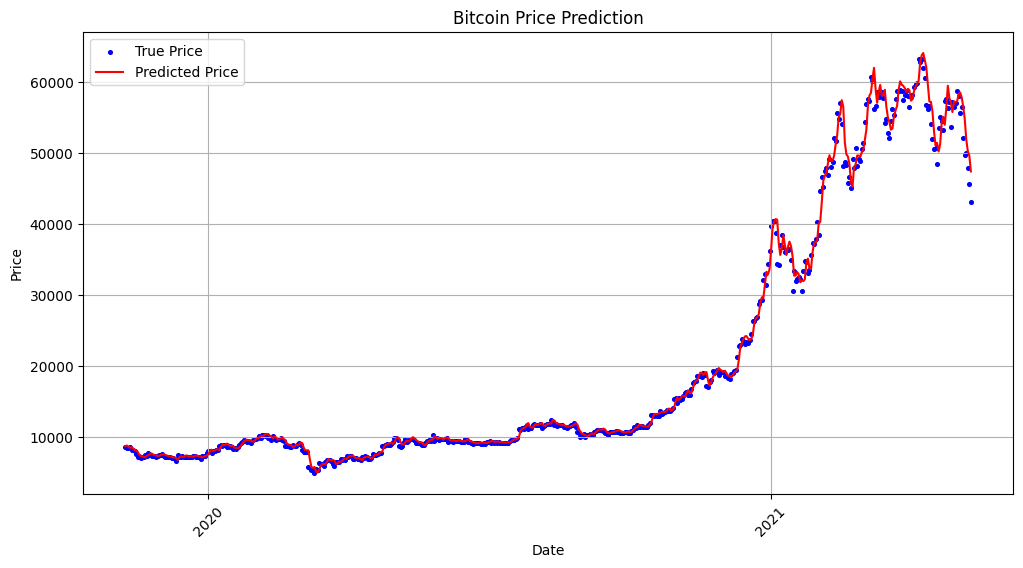

In [29]:
import matplotlib.dates as mdates


# Set up the plot
plt.figure(figsize=(12, 6))

# Plot true and predicted prices
plt.scatter(test.index, ytrue, label='True Price', color='blue',s=7)
plt.plot(test.index, model_predictions, label='Predicted Price', color='red')

# Set the title, labels, and grid
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(axis='both')

# Use mdates to format the x-axis to show years
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as 'YYYY'

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [32]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)
 
model_2 = tf.keras.Sequential([
    layers.Dense(128,activation='relu', input_shape=(config.WINDOW,)),
    layers.Dense(config.HORIZON,activation='linear')
], name="model_2_dense"
)
model_2.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.MAE,metrics=[tf.keras.metrics.MAE])
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               1024      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [33]:
history_2 = model_2.fit(train_dataset,
                        validation_data=test_dataset,
                        epochs=100,
                        callbacks=[create_model_checkpoint_callback(modelname=model_2.name)])

Epoch 1/100
18/18 [==============================] - 2s 92ms/step - loss: 359.0198 - mean_absolute_error: 359.0198 - val_loss: 1761.3801 - val_mean_absolute_error: 1761.3801
Epoch 2/100
18/18 [==============================] - 1s 49ms/step - loss: 361.0837 - mean_absolute_error: 361.0837 - val_loss: 1450.9117 - val_mean_absolute_error: 1450.9117
Epoch 3/100
18/18 [==============================] - 0s 15ms/step - loss: 352.9255 - mean_absolute_error: 352.9255 - val_loss: 1798.1754 - val_mean_absolute_error: 1798.1754
Epoch 4/100
18/18 [==============================] - 1s 67ms/step - loss: 474.0279 - mean_absolute_error: 474.0279 - val_loss: 1227.4950 - val_mean_absolute_error: 1227.4950
Epoch 5/100
18/18 [==============================] - 0s 14ms/step - loss: 708.7378 - mean_absolute_error: 708.7378 - val_loss: 1339.1210 - val_mean_absolute_error: 1339.1210
Epoch 6/100
18/18 [==============================] - 0s 10ms/step - loss: 682.6880 - mean_absolute_error: 682.6880 - val_loss: 202

In [34]:
model_2.evaluate(test_dataset)

5/5 [==============================] - 0s 20ms/step - loss: 1058.5325 - mean_absolute_error: 1058.5325


[1058.532470703125, 1058.532470703125]

In [35]:
model_2 = tf.keras.models.load_model('Models/model_2_dense')
model_2.evaluate(test_dataset)

5/5 [==============================] - 0s 7ms/step - loss: 924.8802 - mean_absolute_error: 924.8802


[924.8801879882812, 924.8801879882812]

In [36]:
model2_predictions = make_predictions(model_2,test_dataset)
model2_predictions[:10]

5/5 [==============================] - 0s 6ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8993.883 , 8893.002 , 8828.711 , 8783.299 , 8736.66  , 8620.662 ,
       8505.539 , 8439.3955, 8224.174 , 7983.602 ], dtype=float32)>

In [37]:
model_2_metric = evaluate_metric(ytrue,model2_predictions)
model_2_metric

{'mae': 924.8801,
 'mse': 2875443.5,
 'RMSE': 1695.7134,
 'mase': 1.6142393,
 'mape': 4.143545}

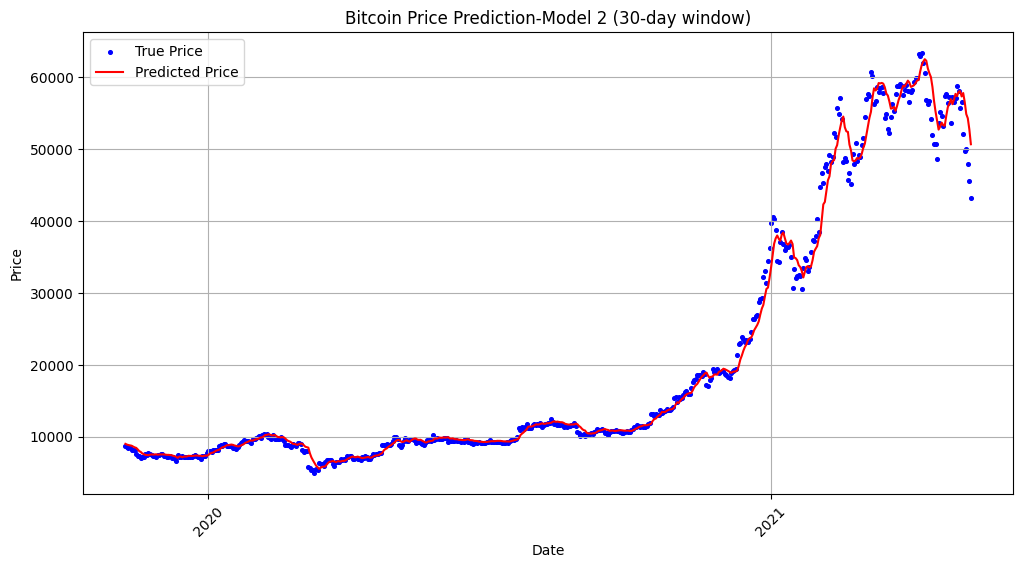

In [40]:
import matplotlib.dates as mdates


# Set up the plot
plt.figure(figsize=(12, 6))

# Plot true and predicted prices
plt.scatter(test.index, ytrue, label='True Price', color='blue',s=7)
plt.plot(test.index, model2_predictions, label='Predicted Price', color='red')

# Set the title, labels, and grid
plt.title('Bitcoin Price Prediction-Model 2 (30-day window)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(axis='both')

# Use mdates to format the x-axis to show years
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as 'YYYY'

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [59]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)
 
model_3 = tf.keras.Sequential([
    layers.Dense(128,activation='relu', input_shape=(config.WINDOW,)),
    layers.Dense(config.HORIZON,activation='linear')
], name="model_3_dense"
)
model_3.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.MAE,metrics=[tf.keras.metrics.MAE])
model_3.summary()

Model: "model_3_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               1024      
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [46]:
history_3 = model_3.fit(train_dataset,
                        validation_data=test_dataset,
                        epochs=100,
                        callbacks=[create_model_checkpoint_callback(modelname=model_3.name)])

Epoch 1/100
18/18 [==============================] - 2s 87ms/step - loss: 268.2644 - mean_absolute_error: 268.2644 - val_loss: 1107.2086 - val_mean_absolute_error: 1107.2086
Epoch 2/100
18/18 [==============================] - 0s 12ms/step - loss: 350.5315 - mean_absolute_error: 350.5315 - val_loss: 2445.4001 - val_mean_absolute_error: 2445.4001
Epoch 3/100
18/18 [==============================] - 0s 13ms/step - loss: 204.6144 - mean_absolute_error: 204.6144 - val_loss: 1152.6113 - val_mean_absolute_error: 1152.6113
Epoch 4/100
18/18 [==============================] - 1s 47ms/step - loss: 203.6785 - mean_absolute_error: 203.6785 - val_loss: 1043.6670 - val_mean_absolute_error: 1043.6670
Epoch 5/100
18/18 [==============================] - 0s 16ms/step - loss: 274.1689 - mean_absolute_error: 274.1689 - val_loss: 1353.3710 - val_mean_absolute_error: 1353.3710
Epoch 6/100
18/18 [==============================] - 1s 64ms/step - loss: 185.0561 - mean_absolute_error: 185.0561 - val_loss: 101

In [47]:
model_3.evaluate(test_dataset)

5/5 [==============================] - 0s 26ms/step - loss: 881.0915 - mean_absolute_error: 881.0916


[881.0914916992188, 881.091552734375]

In [48]:
model_3 = tf.keras.models.load_model('Models/model_3_dense')
model_3.evaluate(test_dataset)

5/5 [==============================] - 0s 8ms/step - loss: 709.5959 - mean_absolute_error: 709.5959


[709.595947265625, 709.595947265625]

In [49]:
model_3_predictions = make_predictions(model_3,test_dataset)
model_3_metric = evaluate_metric(ytrue,model_3_predictions)
model_3_metric

5/5 [==============================] - 0s 15ms/step


{'mae': 709.5958,
 'mse': 1664231.4,
 'RMSE': 1290.0509,
 'mase': 1.238493,
 'mape': 3.2923405}

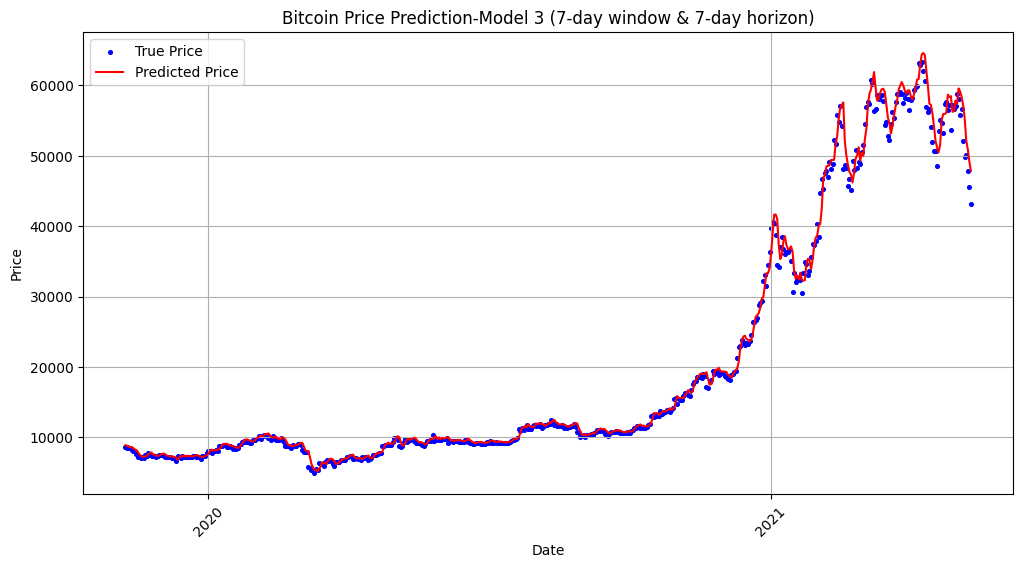

In [51]:
import matplotlib.dates as mdates


# Set up the plot
plt.figure(figsize=(12, 6))

# Plot true and predicted prices
plt.scatter(test.index, ytrue, label='True Price', color='blue',s=7)
plt.plot(test.index, model_3_predictions, label='Predicted Price', color='red')

# Set the title, labels, and grid
plt.title('Bitcoin Price Prediction-Model 3 (7-day window & 7-day horizon)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(axis='both')

# Use mdates to format the x-axis to show years
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as 'YYYY'

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.show()
